In [3]:
import os
import itertools
from PIL import Image

### B- Preprocessing modules

In [4]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

import cv2

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### C- Deep Learning modules

In [5]:
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation
from tensorflow.keras.optimizers import Adam, Adamax


### D- Avoid Warnings

In [6]:
import warnings
warnings.filterwarnings('ignore')

# 2  Preprocessing

## A- Read data

#### ** Training data

In [7]:
# Get Paths of Training and testing directories

Training = '/kaggle/input/brain-tumor-mri-dataset/Training'

# Create two lists to store paths of images and their labels

imgpaths = []
labels =[]


# Convert directories to lists

tr_dir = os.listdir(Training)


In [8]:
# Get paths and Labels of classes and images in Training Directory

for i in tr_dir:
    classpath = os.path.join(Training, i)
    imglist = os.listdir(classpath)
    
    for img in imglist:
        imgpath = os.path.join(classpath, img)
        
        imgpaths.append(imgpath)
        labels.append(i)

In [9]:
# Convert two lists of imgpaths and their labels into series

Paths = pd.Series(imgpaths, name = 'Paths')
Labels = pd.Series(labels, name = 'Labels')

# Concatenate them in one Dataframe called Tr_data

Tr_data = pd.concat([Paths, Labels], axis = 1)


#### ** Testing data

In [10]:
# Get Paths of testing directory

Testing = '/kaggle/input/brain-tumor-mri-dataset/Testing'


# Create two lists to store paths of images and their labels

imgpaths = []
labels =[]


# Convert directories to lists

ts_dir = os.listdir(Testing)

In [11]:
# Get paths and Labels of classes and images in Training Directory

for i in ts_dir:
    classpath = os.path.join(Testing, i)
    imglist = os.listdir(classpath)
    
    for img in imglist:
        imgpath = os.path.join(classpath, img)
        
        imgpaths.append(imgpath)
        labels.append(i)

In [12]:
# Convert two lists of imgpaths and their labels into series

Paths = pd.Series(imgpaths, name = 'Paths')
Labels = pd.Series(labels, name = 'Labels')

# Concatenate them in one Dataframe called Tr_data

Ts_data = pd.concat([Paths, Labels], axis = 1)

In [13]:
Tr_data.shape

(5712, 2)

In [14]:
Tr_data.head()

,Paths,Labels
0,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
1,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
2,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
3,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
4,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary


In [15]:
Ts_data.shape

(1311, 2)

In [16]:
Ts_data.head()

,Paths,Labels
0,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
1,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
2,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
3,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
4,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary


## B- Split Ts_data into Valid and test

In [17]:
valid_df, test_df = train_test_split(Ts_data, train_size = 0.5, shuffle = True, random_state = 123)
print(valid_df.shape)
print(test_df.shape)

(655, 2)
(656, 2)


## C- Create Image Generators

In [18]:
# Define hyperparameters

batch_size = 20
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)


#Create generators

Tr_G = ImageDataGenerator(fill_mode='nearest')

Val_G = ImageDataGenerator()

Test_G = ImageDataGenerator()


## D- Generate Appropriate Data for fitting into model

In [19]:
Train = Tr_G.flow_from_dataframe(Tr_data, x_col = 'Paths', y_col = 'Labels', target_size = img_size, class_mode = 'categorical', color_mode = 'rgb', shuffle = True, batch_size = batch_size)

Found 5712 validated image filenames belonging to 4 classes.


In [20]:
Valid = Val_G.flow_from_dataframe(valid_df, x_col = 'Paths', y_col = 'Labels', target_size = img_size, class_mode = 'categorical', color_mode = 'rgb', shuffle = True, batch_size = batch_size)

Found 655 validated image filenames belonging to 4 classes.


In [21]:
Test = Test_G.flow_from_dataframe(test_df, x_col = 'Paths', y_col = 'Labels', target_size = img_size, class_mode = 'categorical', color_mode = 'rgb', shuffle = False, batch_size = batch_size)

Found 656 validated image filenames belonging to 4 classes.


## E- Represent a sample batch from Train data

### ** Define labels and their indices as a dict 

In [22]:
L_index = Train.class_indices
L_index

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

### ** Store Labels in a list 

In [23]:
Keys = list(L_index.keys())
Keys

['glioma', 'meningioma', 'notumor', 'pituitary']

### ** Get a sample batch 

In [24]:
imgs, labels = next(Train)


### ** Lets visualize

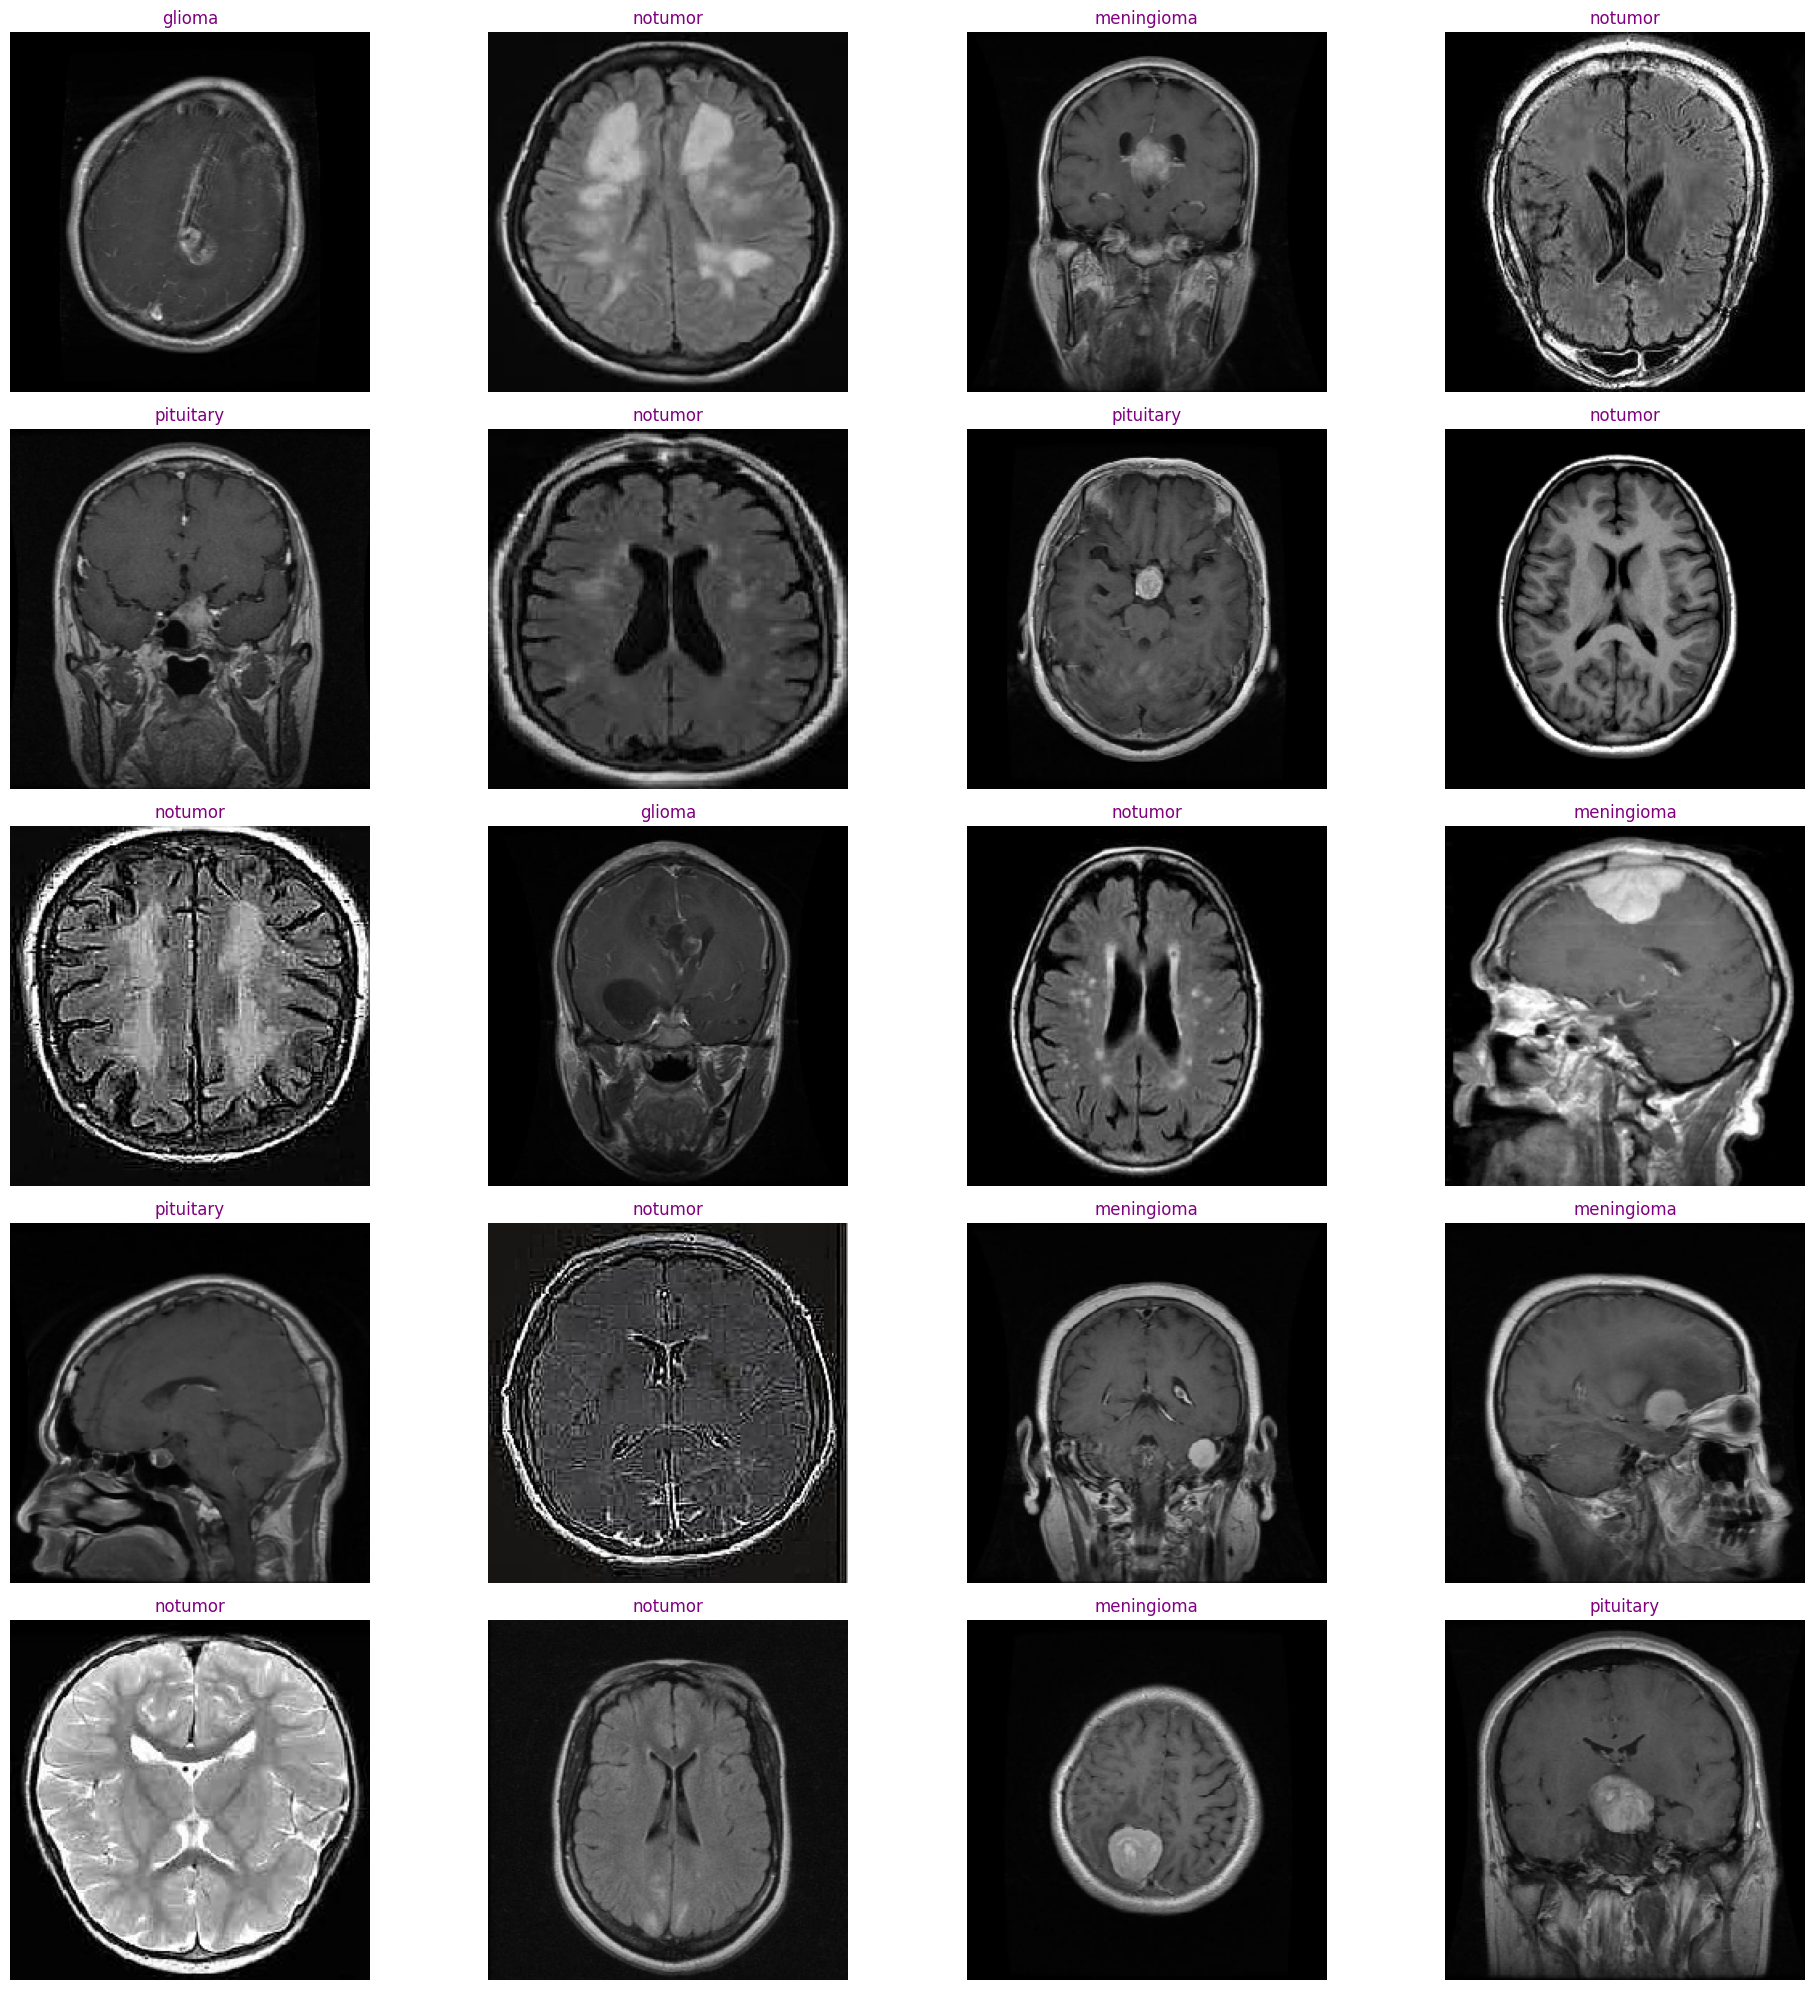

In [25]:
plt.figure(figsize= (20, 20))

for i in range(20):
    plt.subplot(5, 4, i +1)
    im = imgs[i]/255
    plt.imshow(im)
    
    #Labelling
    index = np.argmax(labels[i])
    label = Keys[index]
    plt.title(label, color = 'purple')
    plt.axis('off')
    
plt.tight_layout()    
plt.show()


# 3- Model Structure

In [26]:
# Define hyperparameters

batch_size = 20
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)


In [27]:
Train

In [28]:
# Define number of classes 
counter_classes = len(list(Train.class_indices.keys()))
counter_classes

4

In [29]:
CNN = Sequential([
    Conv2D(filters = 128, kernel_size = (3,3), padding = 'same', activation = 'elu', input_shape = img_shape),
    Conv2D(filters = 128, kernel_size = (3,3), padding = 'same', activation = 'elu'),
    Conv2D(filters = 128, kernel_size = (3,3), padding = 'same', activation = 'elu'),
    MaxPooling2D((2,2)),
    
    Conv2D(filters = 256, kernel_size = (3,3), padding = 'same', activation = 'elu'),
    Conv2D(filters = 256, kernel_size = (3,3), padding = 'same', activation = 'elu'),
    MaxPooling2D((2,2)),
    
    Conv2D(filters = 256, kernel_size = (3,3), padding = 'same', activation = 'elu'),
    Conv2D(filters = 256, kernel_size = (3,3), padding = 'same', activation = 'elu'),
    MaxPooling2D((2,2)),
    
    Conv2D(filters = 128, kernel_size = (3,3), padding = 'same', activation = 'elu'),
    Conv2D(filters = 128, kernel_size = (3,3), padding = 'same', activation = 'elu'),
    MaxPooling2D((2,2)),
    
    Conv2D(filters = 64, kernel_size = (3,3), padding = 'same', activation = 'elu'),
    Conv2D(filters = 64, kernel_size = (3,3), padding = 'same', activation = 'elu'),
    MaxPooling2D((2,2)),
    
    Flatten(),
    
    Dense(256, activation = 'elu'),
    Dense(128, activation = 'elu'),
    Dense(64, activation = 'elu'),
    Dense(32, activation = 'elu'),
    Dense(counter_classes, activation = 'softmax')
])

In [30]:
# Model Compilation
CNN.compile(Adamax(learning_rate = 0.001), loss = 'categorical_crossentropy', metrics = 'accuracy')

In [31]:
# Get summary
CNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 128)     3584      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 128)     147584    
                                                                 
 conv2d_2 (Conv2D)           (None, 224, 224, 128)     147584    
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 128)     0         
 D)                                                              
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 256)     295168    
                                                                 
 conv2d_4 (Conv2D)           (None, 112, 112, 256)     590080    
                                                        

# 4- Model Training 

In [32]:
Train


In [33]:
epochs = 15

history = CNN.fit(x = Train, epochs = epochs, verbose = 1, validation_data = Valid, shuffle = False)


Epoch 1/15
286/286 [==============================] - 102s 313ms/step - loss: 0.7749 - accuracy: 0.7479 - val_loss: 0.5445 - val_accuracy: 0.7893
Epoch 2/15
286/286 [==============================] - 84s 293ms/step - loss: 0.3306 - accuracy: 0.8799 - val_loss: 0.3287 - val_accuracy: 0.8718
Epoch 3/15
286/286 [==============================] - 84s 293ms/step - loss: 0.2712 - accuracy: 0.9014 - val_loss: 0.4939 - val_accuracy: 0.7954
Epoch 4/15
286/286 [==============================] - 84s 293ms/step - loss: 0.2266 - accuracy: 0.9189 - val_loss: 0.3343 - val_accuracy: 0.8840
Epoch 5/15
286/286 [==============================] - 84s 293ms/step - loss: 0.1747 - accuracy: 0.9356 - val_loss: 0.1941 - val_accuracy: 0.9252
Epoch 6/15
286/286 [==============================] - 84s 293ms/step - loss: 0.1468 - accuracy: 0.9459 - val_loss: 0.1984 - val_accuracy: 0.9160
Epoch 7/15
286/286 [==============================] - 84s 293ms/step - loss: 0.1228 - accuracy: 0.9543 - val_loss: 0.1646 - val_a

# 5- Model Evaluation

## A- Define certain Vars

In [34]:
# accuracy and loss of Train

tr_acc = history.history['accuracy']
tr_loss = history.history['loss']


# accuracy and loss or Valid\

v_acc = history.history['val_accuracy']
v_loss = history.history['val_loss']


# highest value of v_acc by getting its index

index_acc = np.argmax(v_acc)
high_Vacc = v_acc[index_acc]


# lowest value of v_loss by getting index

index_loss = np.argmin(v_loss)
low_Vloss = v_loss[index_loss]


# n. of epochs based on length of tr_acc values

Epochs =[]
for i in range(len(tr_acc)):
    Epochs.append (i+1)

    
# Define best epoch

best_acc = f'Best epoch ={str(index_acc +1)}'
best_loss = f'Best epoch ={str(index_loss+1)}'

In [35]:
# check Epochs and tr_acc
print(Epochs)
print(tr_acc)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
[0.7478991746902466, 0.8799019455909729, 0.9014355540275574, 0.9189425706863403, 0.9355742335319519, 0.9459033608436584, 0.9543067216873169, 0.9611344337463379, 0.9670868515968323, 0.9758403301239014, 0.9798669219017029, 0.9826680421829224, 0.9851190447807312, 0.9866946935653687, 0.9922969341278076]


## B- Lets Visualise

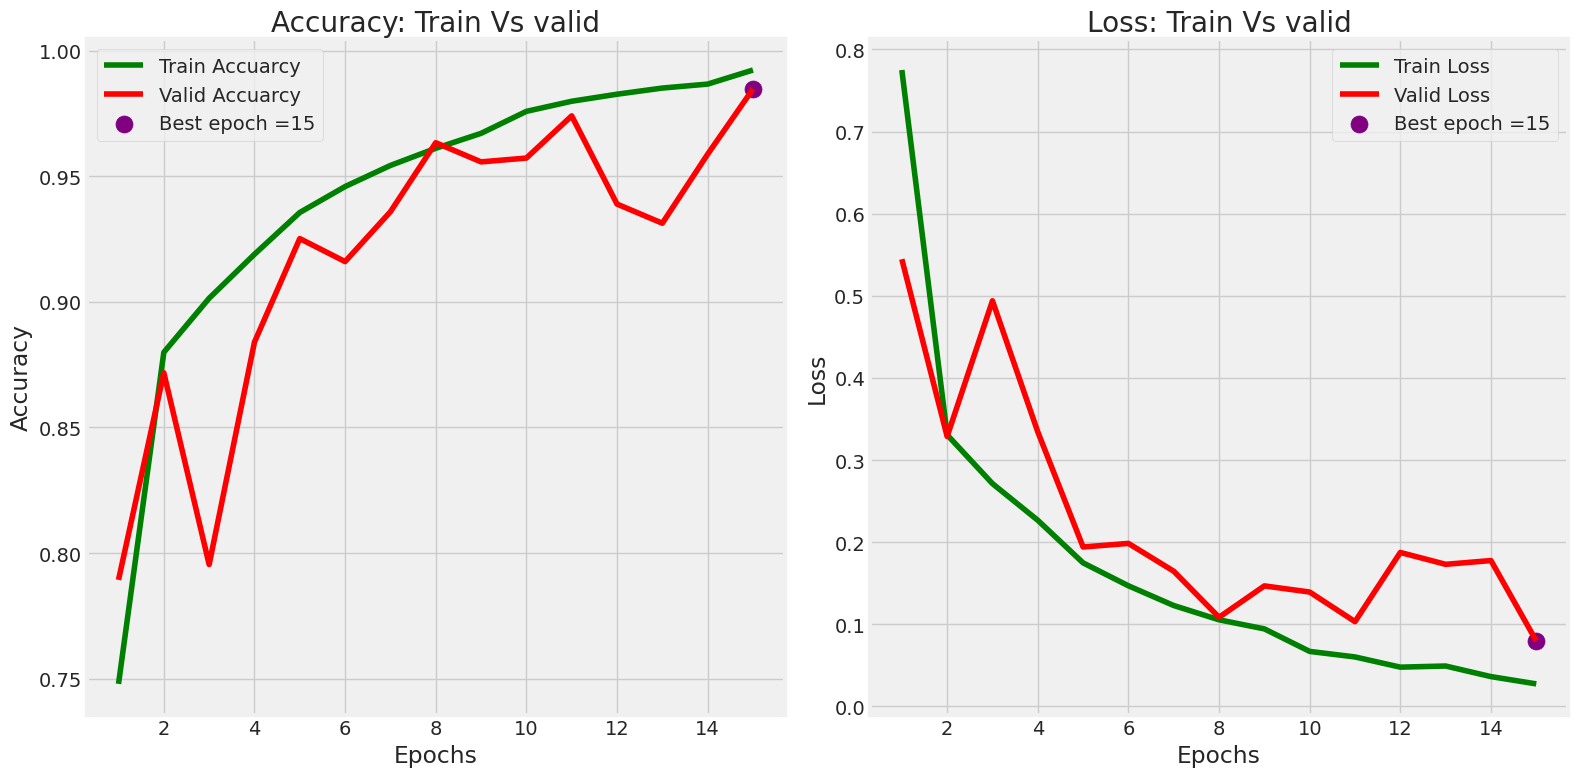

In [36]:
plt.figure(figsize = (16, 8))
plt.style.use('fivethirtyeight')


plt.subplot(1,2,1)
plt.plot(Epochs, tr_acc, "g", label = "Train Accuarcy")
plt.plot(Epochs, v_acc, "r", label = "Valid Accuarcy")
plt.scatter(index_acc+1, high_Vacc, s= 150, color = 'purple', label = best_acc)

plt.title("Accuracy: Train Vs valid")
plt. xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(1,2,2)
plt.plot(Epochs, tr_loss, "g", label = "Train Loss")
plt.plot(Epochs, v_loss, "r", label = "Valid Loss")
plt.scatter(index_loss+1, low_Vloss, s= 150, color = 'purple', label = best_loss)

plt.title("Loss: Train Vs valid")
plt. xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## C- Get scores

In [37]:
# Define Vars
Train_sc = CNN.evaluate(Train, verbose = 0)
Valid_sc = CNN.evaluate(Valid, verbose = 0)
Test_sc =CNN.evaluate(Test, verbose = 0)

#Print
print('Train Scores : \n    accuracy:', Train_sc[1], '\n      Loss: ', Train_sc[0], '\n________________________')
print('Valid Scores : \n    accuracy:', Valid_sc[1], '\n      Loss: ', Valid_sc[0], '\n________________________')
print('Test Scores : \n    accuracy:', Test_sc[1], '\n      Loss: ', Test_sc[0], '\n________________________')

Train Scores : 
    accuracy: 0.9973739385604858 
      Loss:  0.0065922182984650135 
________________________
Valid Scores : 
    accuracy: 0.9847328066825867 
      Loss:  0.07967016845941544 
________________________
Test Scores : 
    accuracy: 0.9817073345184326 
      Loss:  0.08019401878118515 
________________________


# 6- Model prdictions

In [38]:
predictions = CNN.predict_generator(Test)
y_pred = np.argmax(predictions, axis = 1)

#Chack
print(predictions)
print(y_pred)

[[5.65990943e-09 2.18906935e-04 9.99779522e-01 1.50136350e-06]
 [2.06036042e-04 9.99793828e-01 3.12277049e-09 1.29375806e-07]
 [1.00000000e+00 6.93437599e-11 1.08769181e-13 9.20379675e-11]
 ...
 [9.99959826e-01 3.34838490e-09 8.71079749e-07 3.92976290e-05]
 [3.60345109e-09 1.39730965e-08 2.31261191e-10 1.00000000e+00]
 [9.29748524e-07 9.88556743e-01 1.13090362e-04 1.13291964e-02]]
[2 1 0 3 2 1 1 0 2 0 0 2 1 1 1 1 2 0 0 2 0 0 3 3 0 2 3 1 3 2 3 3 2 2 1 3 0
 1 0 3 3 2 2 0 1 1 1 2 2 0 3 2 2 1 3 1 2 0 3 2 1 0 2 2 2 0 1 2 0 2 3 0 3 0
 0 3 2 2 0 1 1 2 2 2 1 3 1 3 1 2 0 3 1 3 1 1 1 1 2 2 3 2 2 0 1 2 3 1 2 2 3
 1 0 3 2 0 2 1 0 1 0 2 1 2 3 2 0 3 3 2 3 1 3 2 1 3 0 1 1 0 2 2 3 1 3 0 1 0
 1 1 3 3 1 2 2 3 2 2 2 3 0 3 2 3 1 1 0 0 3 3 3 3 0 3 3 2 3 1 0 0 0 3 3 3 1
 0 3 3 2 3 0 3 1 0 2 2 3 3 3 1 3 2 0 2 0 3 3 2 3 3 1 1 3 2 2 3 2 2 2 1 3 1
 2 2 0 2 3 0 3 0 0 1 0 2 0 2 1 3 2 2 0 2 2 3 3 1 2 1 2 2 0 2 1 1 1 1 0 3 2
 3 2 3 1 1 1 0 1 2 0 1 3 3 2 3 0 2 2 2 0 0 1 1 1 2 1 0 0 3 1 0 2 3 1 1 2 3
 0 2 1 0 0 2 1 2

In [39]:
# Use n. of keys of  Class indices to greate confusion matrix
Test_cl_ind = Test.class_indices
 
# Get Keys
classes = list(Test_cl_ind.keys())

#CM
cm = confusion_matrix(Test.classes, y_pred)
cm

array([[139,  10,   0,   0],
       [  1, 141,   1,   0],
       [  0,   0, 200,   0],
       [  0,   0,   0, 164]])

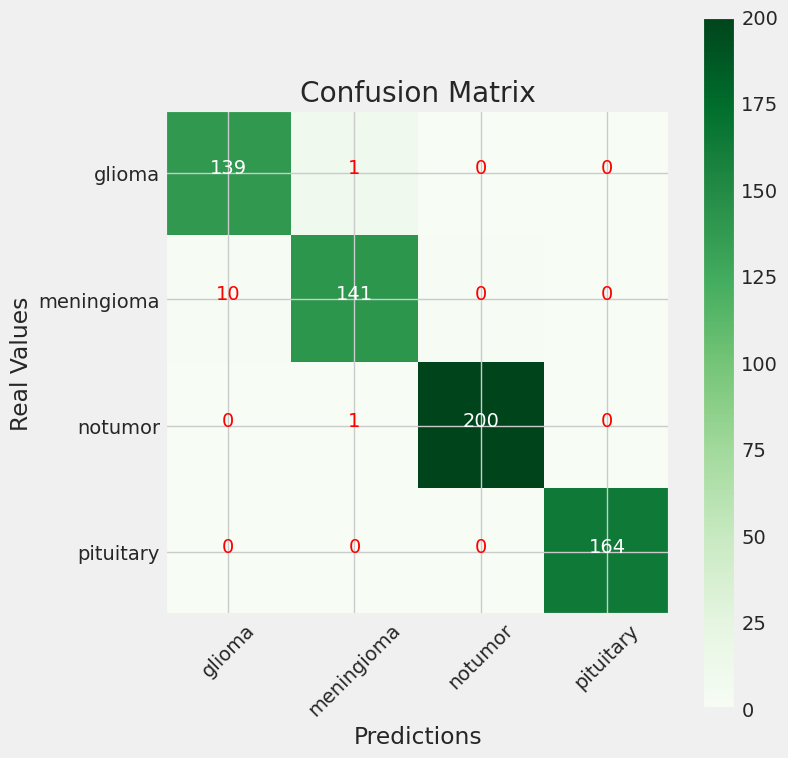

In [40]:
#visualise it
plt.figure(figsize =(8, 8))
plt.imshow(cm, interpolation = 'nearest', cmap = plt.cm.Greens)
plt.title("Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes,rotation = 45)
plt.yticks(tick_marks, classes)

thresh = cm.max()/2
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(i, j, cm[i, j], horizontalalignment = 'center', color = 'white' if cm[i,j] > thresh  else 'red')
    
plt.tight_layout()
plt.xlabel('Predictions')
plt.ylabel('Real Values')
plt.show()


In [41]:
# Calssification Report
print(classification_report(Test.classes, y_pred, target_names = classes))

              precision    recall  f1-score   support

      glioma       0.99      0.93      0.96       149
  meningioma       0.93      0.99      0.96       143
     notumor       1.00      1.00      1.00       200
   pituitary       1.00      1.00      1.00       164

    accuracy                           0.98       656
   macro avg       0.98      0.98      0.98       656
weighted avg       0.98      0.98      0.98       656



# 7- Save Model

In [42]:
CNN.save('CNN.h5')

# 8- Load Model to get prediction

## A- Load save model

In [43]:
CNN = tf.keras.models.load_model("/kaggle/working/CNN.h5", compile = False)
CNN.compile(Adamax(learning_rate = 0.001), loss = 'categorical_crossentropy', metrics = 'accuracy')

## B- Test a model by acertain image path

In [53]:
# image path

from PIL import Image
path = '/kaggle/input/brain-tumor-mri-dataset/Testing/meningioma/Te-meTr_0001.jpg'
p2='/kaggle/input/brain-tumor-mri-dataset/Testing/glioma/Te-glTr_0000.jpg'
p3='/kaggle/input/brain-tumor-mri-dataset/Testing/glioma/Te-gl_0028.jpg'
p5='/kaggle/input/brain-tumor-mri-dataset/Testing/notumor/Te-noTr_0007.jpg'
# open image
img = Image.open(p5)

# Preprocess
img1 = img.resize((224, 224))
iArray = tf.keras.preprocessing.image.img_to_array(img1)
iArray = tf.expand_dims(iArray, 0)

#Predictions ratio for each class
p = CNN.predict(iArray)

#Get score:
score = tf.nn.softmax(p[0])
print('\nPredictions of given image:  \n\n', score)


# Get class whose max ratio
cl_labels = ['glioma', 'meningioma', 'notumor', 'pituitary']
print(f'-------------------------\nClass whose max ratio: \n\n{cl_labels[np.argmax(p)]}')

#
print(f"{cl_labels[np.argmax(p)]}")


1/1 [==============================] - 0s 20ms/step

Predictions of given image:  

 tf.Tensor([0.17513143 0.17526957 0.4746002  0.17499882], shape=(4,), dtype=float32)
-------------------------
Class whose max ratio: 

notumor
notumor


In [54]:
from IPython.display import FileLink

# Path to the file you want to create a download link for
file_path = "CNN.h5"

# Generate a download link for the file
FileLink(file_path)


/kaggle/working/CNN.h5